# Generative Adversarial Networks

This practical session will focus on generative modeling with Generative Adversarial Networks. We will implement the model and train it on MNIST. We will also implement a couple of functions which will allow us to sample new images and perform latent space traversals. A great tutorial is available [here](https://www.youtube.com/watch?v=HGYYEUSm-0Q).

**Note**: The easiest way to use this tutorial is [as a colab notebook](https://colab.sandbox.google.com/github/tensorflow/lucid/blob/master/notebooks/tutorial.ipynb). Enable a free GPU by going to:

> **Runtime**   →   **Change runtime type**   →   **Hardware Accelerator: GPU**


In [0]:
import matplotlib.pyplot as plt 
import numpy as np
import tensorflow as tf

import seaborn as sns
sns.set_style("whitegrid")
%matplotlib inline

In [2]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use urllib or similar directly.
Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py fr

## Model and loss

As discussed in the lecture, a GAN consists of a generator and a discriminator. In this example, we will as simple CNN from [InfoGAN](https://arxiv.org/abs/1606.03657).

1.   The generator will take a random seed and generate an image.
2.   The discriminator will output a value in [0, 1] denoting the "realness" of the input.

We will use the [non-saturing loss](https://arxiv.org/abs/1406.2661) and optimize the generator and discriminator using alternating stochastic optimization.


In [0]:
def lrelu(inputs, leak=0.2):
  """Leaky ReLu."""
  return tf.maximum(inputs, leak * inputs)

def spectral_norm(w, iteration=1):
  w_shape = w.shape.as_list()
  w = tf.reshape(w, [-1, w_shape[-1]])

  u = tf.get_variable("u", [1, w_shape[-1]], initializer=tf.random_normal_initializer(), trainable=False)

  u_hat = u
  v_hat = None
  for i in range(iteration):
      """
      power iteration
      Usually iteration = 1 will be enough
      """
      v_ = tf.matmul(u_hat, tf.transpose(w))
      v_hat = tf.nn.l2_normalize(v_)
      u_ = tf.matmul(v_hat, w)
      u_hat = tf.nn.l2_normalize(u_)

  u_hat = tf.stop_gradient(u_hat)
  v_hat = tf.stop_gradient(v_hat)

  sigma = tf.matmul(tf.matmul(v_hat, w), tf.transpose(u_hat))

  with tf.control_dependencies([u.assign(u_hat)]):
      w_norm = w / sigma
      w_norm = tf.reshape(w_norm, w_shape)


  return w_norm

def batch_norm(x, name):
  """Batch normalization layer."""
  return tf.contrib.layers.batch_norm(
      x, decay=0.999, epsilon=0.001, updates_collections=None,
      scale=True, fused=False, scope=name)

def linear(inputs, output_size, name):
  """Linear layer."""
  shape = inputs.get_shape().as_list()
  with tf.variable_scope(name):
    w = tf.get_variable("w", [shape[1], output_size], initializer=tf.random_normal_initializer(stddev=0.02))
    w = spectral_norm(w)
    b = tf.get_variable("b", [output_size], initializer=tf.constant_initializer(0.0))
    return tf.matmul(inputs, w) + b

def conv2d(inputs, output_dim, k_h, k_w, d_h, d_w, name):
  """2D convolution layer."""
  with tf.variable_scope(name):
    w = tf.get_variable("w", [k_h, k_w, inputs.shape[-1].value, output_dim],
                        initializer=tf.random_normal_initializer(stddev=0.02))
    # i change from w to spectralnorm(w)
    outputs = tf.nn.conv2d(inputs, spectral_norm(w), strides=[1, d_h, d_w, 1], padding="SAME")
    bias = tf.get_variable("b", [output_dim], initializer=tf.constant_initializer(0.0))
    return outputs + bias

def deconv2d(inputs, output_shape, k_h, k_w, d_h, d_w, name):
  """Transposed 2D convolution layer."""
  with tf.variable_scope(name):
    w = tf.get_variable("w", [k_h, k_w, output_shape[-1], inputs.get_shape()[-1]], 
                        initializer=tf.random_normal_initializer(stddev=0.02))
    deconv = tf.nn.conv2d_transpose(inputs, spectral_norm(w), output_shape=output_shape, strides=[1, d_h, d_w, 1])
    bias = tf.get_variable("b", [output_shape[-1]], initializer=tf.constant_initializer(0.0))
    return tf.reshape(tf.nn.bias_add(deconv, bias), tf.shape(deconv))



In [4]:
class GAN(object):

  def __init__(self, batch_size, z_dim, learning_rate=0.0001):
    self.z_dim = z_dim
    self.learning_rate = learning_rate
    self.batch_size = 64
    self.sess = tf.InteractiveSession()
    self.x = tf.placeholder(name='x', dtype=tf.float32, shape=[batch_size, 28, 28, 1])
    self.z = tf.placeholder(tf.float32, [batch_size, self.z_dim], name="z")
    self.build()

  def z_generator(self):
    return np.random.uniform(-1, 1, size=(self.batch_size, self.z_dim))

  def generator(self):
    bs, h, w, c = self.x.shape.as_list()
    with tf.variable_scope("generator", reuse=tf.AUTO_REUSE):
      net = linear(self.z, 1024, "fc1")
      net = lrelu(batch_norm(net, "bn1"))
      net = linear(net, 128 * (h // 4) * (w // 4), "fc2")
      net = lrelu(batch_norm(net, "bn2"))
      net = tf.reshape(net, [bs, h // 4, w // 4, 128])
      net = deconv2d(net, [bs, h // 2, w // 2, 64], 4, 4, 2, 2, "deconv1")
      net = lrelu(batch_norm(net, "bn3"))
      net = deconv2d(net, [bs, h, w, c], 4, 4, 2, 2, "deconv2")
      return tf.nn.sigmoid(net)

  def discriminator(self, x):
    bs, h, w, c = self.x.shape.as_list()
    with tf.variable_scope("discriminator", reuse=tf.AUTO_REUSE):
      net = lrelu(conv2d(x, 64, 4, 4, 2, 2, "conv1"))
      net = lrelu(conv2d(net, 128, 4, 4, 2, 2, "conv2"))
      net = tf.reshape(net, [bs, -1])
      net = lrelu(linear(net, 1024, "fc1"))
      return linear(net, 1, "fc2")
      
  def loss(self, d_real_logits, d_fake_logits):
    with tf.name_scope("non_saturating_loss"):
      d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
          logits=d_real_logits, labels=tf.ones_like(d_real_logits),
          name="cross_entropy_d_real"))
      d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
          logits=d_fake_logits, labels=tf.zeros_like(d_fake_logits),
          name="cross_entropy_d_fake"))
      d_loss = d_loss_real + d_loss_fake
      g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
          logits=d_fake_logits, labels=tf.ones_like(d_fake_logits),
          name="cross_entropy_g"))
      return d_loss, g_loss
  
  def build(self):
    self.fake_images = self.generator()
    real_logits = self.discriminator(self.x)
    fake_logits = self.discriminator(self.fake_images)
    with tf.variable_scope("loss", reuse=tf.AUTO_REUSE):
      self.d_loss, self.g_loss = self.loss(real_logits, fake_logits)
      self.d_optim = tf.train.AdamOptimizer(self.learning_rate, beta1=0.5).minimize(self.d_loss)
      self.g_optim = tf.train.AdamOptimizer(self.learning_rate, beta1=0.5).minimize(self.g_loss)

  def train(self, n_batches=100):
    batch_size = self.batch_size
    tf.global_variables_initializer().run()
    for batch_idx in range(n_batches):
      batch_x = mnist.train.next_batch(batch_size)[0].reshape([-1, 28, 28, 1])
      batch_z = self.z_generator()
      _, d_loss = self.sess.run(
        [self.d_optim, self.d_loss], feed_dict={self.x: batch_x, self.z: batch_z})
      batch_z = self.z_generator()
      _, g_loss = self.sess.run(
        [self.g_optim, self.g_loss], feed_dict={self.z: batch_z})
      if batch_idx % int(n_batches / 10) == 0:
        print("[Batch [%05d] -> D loss [%.2f] G loss [%.2f]" % (batch_idx, d_loss, g_loss))

  def sample(self):
    z_sample = self.z_generator()
    return self.sess.run(self.fake_images, feed_dict={self.z: z_sample})

gan = GAN(batch_size=64, z_dim=64)
gan.train(n_batches=20000)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
[Batch [00000] -> D loss [1.37] G loss [0.87]
[Batch [02000] -> D loss [0.75] G loss [0.65]
[Batch [04000] -> D loss [0.75] G loss [0.65]
[Batch [06000] -> D loss [0.76] G loss [0.64]
[Batch [08000] -> D loss [0.77] G loss [0.63]
[Batch [10000] -> D loss [0.78] G loss [0.62]
[Batch [12000] -> D loss [0.79] G loss [0.62]
[Batch [14000] -> D loss [0.81] G loss [0.60]
[Batch [16000] -> D loss [0.83] G loss [0.59]
[Batch [18000] -> D loss [0.84] G loss [0.58]


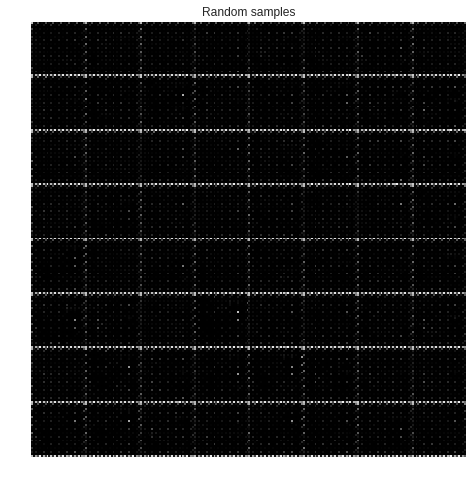

In [5]:
def plot(fig_height, fig_width, canvas, title):
  plt.figure(figsize=(fig_height, fig_width))
  plt.imshow(canvas, cmap='gray')
  plt.axis('off')
  plt.title(title)

def visualize_random_samples(model):
  n = int(np.sqrt(model.batch_size))
  h = w = model.x.shape.as_list()[1]
  x_generated = model.sample().reshape([n, n, h, w])
  canvas = np.zeros((h * n, w * n))
  for i in range(n):
    for j in range(n):
      canvas[i*h:(i+1)*h, j*w:(j+1)*w] = x_generated[i][j]
  plot(8, 8, canvas, "Random samples")

visualize_random_samples(gan)

**Things to Try**

Change loss function to Least Square to see the parameters by fixing everything else.
Why do we use lrelu for the discriminator in GAN